# Cython Testing

Testing compilation and running of cython module

##Notes
- Copied from labeyrieClasses : 48s
- With all extra fluff and if statements removed: 47s
- Casting to np.float32 instead of float: 22.9s
- Casting entire 1000x512x512 fits cube to np.float32 takes 0.855s
    - Casting entire 1000x512x512 fits cube to float takes 18.5s
- No significant gain from casting the entire fits cube first (rather than image by image)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2,ifft2,fftshift
from labeyrieClasses import target

%matplotlib inline
%load_ext cython

In [2]:
# Comparison of bare Python to Cython for preprocessing FITS data
binary = target()

In [3]:
# Import demo .FITS file
binary.fits.fileName = "/home/niels/Documents/FITS/KP330.fits"
binary.fits.read(numDimensions=3)

Filename: /home/niels/Documents/FITS/KP330.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      62   (512, 512, 1000)   float32   
None


In [ ]:
%%timeit -n 1 -r 1
binary.fits.read(numDimensions=3)
# Preprocess .FITS with Python, time it
# Command copied from labeyrieClasses

if (len(binary.fits.data.shape) == 3):
    # Generate empty array the size of an image to be used to accumulate
    #  PSD values before averaging.
    psdSum = np.zeros(binary.fits.data.shape[1:3])

    imgNum = np.shape(binary.fits.data)[0] # Number of images
    imgIncrement = imgNum/20 # How often to display a status message

    # Looping through all images in cube
    for index,img in enumerate(binary.fits.data):

        # Print current file being processed
        if (((index+1) % imgIncrement) == 0):
            print("Processed Image #: ",(index+1),"/",imgNum)

        # FFT function requires little-endian data, so casting it
        img = img.astype(float)

        # Calculate 2D power spectrum
        # This gives us only real values
        psdImg = np.abs(fft2(img))**2

        # Accumulate current PSD value
        psdSum = np.add(psdSum,psdImg)

    # Divide by # of images to calculate average
    psdAvg = np.divide(psdSum,imgNum)

    # Normalizing FFT
    psdAvg = np.divide(psdAvg, (psdAvg.size)**2)

#Otherwise if FITS data is only one image
elif (len(binary.fits.shape) == 2):
    # FFT function requires little-endian data, so casting it
    img = binary.fits.astype(float)

    # Calculate 2D power spectrum
    # This gives us only real values
    psdImg = np.abs(fft2(img))**2

    # Normalizing FFT
    psdAvg = np.divide(psdImg, (psdImg.size)**2)

    binary.psd.data = fftshift(psdAvg)

In [ ]:
%%timeit -n 1 -r 1
binary.fits.read(numDimensions=3)
# Preprocess .FITS with Python, time it
# Command copied from labeyrieClasses
# Modified with all "if" statements removed

psdSum = np.zeros(binary.fits.data.shape[1:3])

imgNum = np.shape(binary.fits.data)[0] # Number of images
imgIncrement = imgNum/20 # How often to display a status message

# Looping through all images in cube
for index,img in enumerate(binary.fits.data):

    # FFT function requires little-endian data, so casting it
    img = img.astype(float)

    # Calculate 2D power spectrum
    # This gives us only real values
    psdImg = np.abs(fft2(img))**2

    # Accumulate current PSD value
    psdSum = np.add(psdSum,psdImg)

# Divide by # of images to calculate average
psdAvg = np.divide(psdSum,imgNum)

# Normalizing FFT
psdAvg = np.divide(psdAvg, (psdAvg.size)**2)

In [ ]:
%%timeit -n 1 -r 1
binary.fits.read(numDimensions=3)
# Preprocess .FITS with Python, time it
# Command copied from labeyrieClasses
# Modified with all "if" statements removed
# Casting to np.float32 instead

psdSum = np.zeros(binary.fits.data.shape[1:3])

imgNum = np.shape(binary.fits.data)[0] # Number of images
imgIncrement = imgNum/20 # How often to display a status message

# Looping through all images in cube
for index,img in enumerate(binary.fits.data):

    # FFT function requires little-endian data, so casting it
    img = img.astype(np.float32)

    # Calculate 2D power spectrum
    # This gives us only real values
    psdImg = np.abs(fft2(img))**2

    # Accumulate current PSD value
    psdSum = np.add(psdSum,psdImg)

# Divide by # of images to calculate average
psdAvg = np.divide(psdSum,imgNum)

# Normalizing FFT
psdAvg = np.divide(psdAvg, (psdAvg.size)**2)

In [ ]:
# Checking difference in casting to different types
%timeit test = binary.fits.data.astype(np.float32)
%timeit test = binary.fits.data.astype(float)

Filename: /home/niels/Documents/FITS/KP330.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      62   (512, 512, 1000)   float32   
None
1 loops, best of 1: 31.4 s per loop


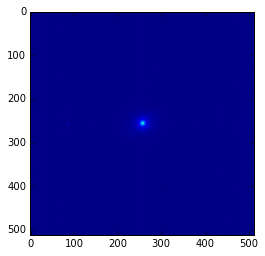

In [5]:
%%timeit -n 1 -r 1
binary.fits.read(numDimensions=3)
# Preprocess .FITS with Python, time it
# Command copied from labeyrieClasses
# Modified with all "if" statements removed
# Trying to pre-cast the entire cube before the loop

psdSum = np.zeros(binary.fits.data.shape[1:3])

imgNum = np.shape(binary.fits.data)[0] # Number of images
imgIncrement = imgNum/20 # How often to display a status message

dataFloat32 = binary.fits.data.astype(np.float32)

# Looping through all images in cube
for index,img in enumerate(dataFloat32):

    # Calculate 2D power spectrum
    # This gives us only real values
    psdImg = np.abs(fft2(img))**2

    # Accumulate current PSD value
    psdSum = np.add(psdSum,psdImg)

# Divide by # of images to calculate average
psdAvg = np.divide(psdSum,imgNum)

# Normalizing FFT
psdAvg = np.divide(psdAvg, (psdAvg.size)**2)

# Shifting FFT
psdAvg = np.fft.fftshift(psdAvg)

plt.imshow(np.log10(psdAvg+1E-3))

In [9]:
%%cython --annotate
# A test cython module
cimport numpy as np
import numpy as np

def takePSD(np.ndarray image):

    cdef np.ndarray image_f32 = np.zeros([512,512], dtype=np.float32)
    cdef np.ndarray psd = np.zeros([512,512], dtype=np.float32)

    #print("Hello World")
    
    # FFT function requires little-endian data, so casting it
    image_f32 = image.astype(np.float32)

    # Calculate 2D power spectrum
    # This gives us only real values
    psd = np.power(np.abs(np.fft.fft2(image_f32)),2)
    
    # Normalizing FFT
    psd = np.divide(psd, (psd.size)**2)
    
    # Shifting FFT
    psd = np.fft.fftshift(psd)

    return psd
    #return image_f32


Filename: /home/niels/Documents/FITS/KP330.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      62   (512, 512, 1000)   float32   
None


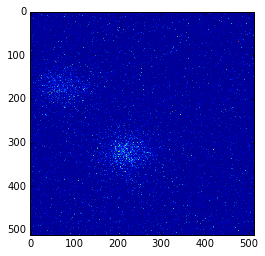

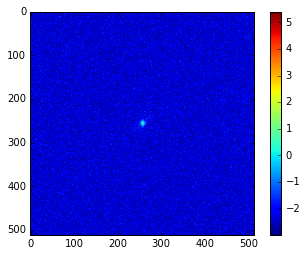

In [11]:
binary.fits.read(numDimensions=3)
# Run the test Cython function

psd = takePSD(binary.fits.data[0])

plt.figure()
plt.imshow(binary.fits.data[0])

plt.figure()
plt.imshow(np.log10(psd+1E-3))
plt.colorbar()
